# Aplicación de Multilayer Perceptron en clasificación de dibujos hechos a mano usando el conjunto de imágenes QuickDraw -10

- **Nombre:** Diego Valdés
- **Profesora:** Violeta Chang Camacho



## Objetivo de la tarea

El objetivo de esta tarea es entender y aplicar redes neuronales para clasificar imágenes. Así, en esta tarea el foco estará en la clasificación de dibujos hechos a mano usando el conjunto de imágenes QuickDraw

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from tqdm import trange
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim 
from sklearn.decomposition import PCA



## Extracción de los datos de QuickDraw-10 y QuickDraw-Animals
Se verifica que la carpeta contiene las siguientes carpetas y archivos:

* mapping.txt: Mapea las etiquetas a las clases.

* train.txt: Contiene las rutas a las imágenes de entrenamiento y sus respectivas etiquetas.

* test.txt: Contiene las rutas a las imágenes de prueba y sus respectivas etiquetas.

* images/: Carpeta con las imágenes de todos los dibujos.

In [2]:
# Ruta del archivo descomprimido
ruta_base10 = "C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea2\\QuickDraw-10"

print("Archivos dentro de QuickDraw-10:")
archivos = os.listdir(ruta_base10)

# Imprimir la lista de archivos
for archivo in archivos:
    print(archivo)


Archivos dentro de QuickDraw-10:
images
mapping.txt
test.txt
train.txt


In [3]:
# Ruta del archivo descomprimido
ruta_baseA = "C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea2\\QuickDraw-Animals"

print("Archivos dentro de QuickDraw-Animals:")
archivos = os.listdir(ruta_baseA)

# Imprimir la lista de archivos
for archivo in archivos:
    print(archivo)

Archivos dentro de QuickDraw-Animals:
mapping.txt
test_images
train_images


# Carga y estructura de los datos de Quickdraw-10


Cada imagen es convertida a una matriz NumPy de 256x256 elementos, donde cada valor representa la intensidad de un píxel (0 a 255). Como resultado:

* X_train10.shape = (9834, 256): contiene 9834 imágenes de entrenamiento.

* y_train10.shape = (9834,): etiquetas correspondientes a X_train, con valores entre 0 y 9 (una por clase).

* X_test10.shape = (1166, 256): contiene 1166 imágenes de prueba.

* y_test10.shape = (1166,): etiquetas correspondientes a X_test.

In [4]:
# Para QuickDraw-10

etiquetas_quickdraw10 = {
    0: "sink",1: "castle",2: "lion",
    3: "teapot",4: "flashlight",5: "blackberry",
    6: "spreadsheet",7: "bandage", 8: "remote-control",9: "trombone"
}

In [5]:
IMG_SIZE = 256

def cargartxt(txt_path, base_dir):
    X = []
    y = []
    with open(txt_path, 'r') as f:
        lineas = f.readlines()
        for linea in tqdm(lineas, desc=f"Cargando {os.path.basename(txt_path)}"):
            ruta_rel, etiqueta = linea.strip().split()
            ruta_img = os.path.join(base_dir, ruta_rel)
            try:
                img = Image.open(ruta_img).convert("L").resize((IMG_SIZE, IMG_SIZE))
                img_np = np.array(img, dtype=np.float32) / 255.0  
                img_flat = img_np.flatten()  
                X.append(img_flat)
                y.append(int(etiqueta))
            except Exception as e:
                print(f"Error al leer {ruta_img}: {e}")
    return np.array(X), np.array(y)

BASE_DIR ="C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea2\\QuickDraw-10"
X_train10, y_train10 = cargartxt(os.path.join(BASE_DIR, "train.txt"), BASE_DIR)
X_test10, y_test10 = cargartxt(os.path.join(BASE_DIR, "test.txt"), BASE_DIR)

print("Antes de PCA:")
print("X_train:", X_train10.shape, "y_train:", y_train10.shape)
print("X_test:", X_test10.shape, "y_test:", y_test10.shape)

# PCA reducción a 256 componentes
pca = PCA(n_components=256)
X_train10_pca = pca.fit_transform(X_train10)
X_test10_pca = pca.transform(X_test10)

print("Después de PCA:")
print("X_train_pca:", X_train10_pca.shape)
print("X_test_pca:", X_test10_pca.shape)


Cargando test.txt: 100%|██████████| 1166/1166 [00:12<00:00, 92.98it/s]


Antes de PCA:
X_train: (9834, 65536) y_train: (9834,)
X_test: (1166, 65536) y_test: (1166,)
Después de PCA:
X_train_pca: (9834, 256)
X_test_pca: (1166, 256)


# Carga y estructura de los datos de Quickdraw-Animals

Cada imagen es convertida a una matriz NumPy de 256x256 elementos, donde cada valor representa la intensidad de un píxel (0 a 255). Como resultado:

* X_trainA.shape = (12000, 256): contiene 12000 imágenes de entrenamiento.

* y_trainA.shape = (12000,): etiquetas correspondientes a X_train, con valores entre 0 y 11 (una por clase).

* X_testA.shape = (2399, 256): contiene 2399 imágenes de prueba.

* y_testA.shape = (2399,): etiquetas correspondientes a X_test.

In [6]:
etiquetas_animals = {
        "sheep": 0, "bear": 1, "bee": 2, "cat": 3, "camel": 4,
        "cow": 5, "crab": 6, "crocodile": 7, "duck": 8, "elephant": 9,
        "dog": 10, "giraffe": 11
    }

In [7]:

def cargar_dataset_animals(path_dir):
    X = []
    y = []
    
    for clase in os.listdir(path_dir):
        carpeta_clase = os.path.join(path_dir, clase)
        if not os.path.isdir(carpeta_clase):
            continue
        label = etiquetas_animals.get(clase)
        if label is None:
            continue
        for archivo in os.listdir(carpeta_clase):
            archivo_path = os.path.join(carpeta_clase, archivo)
            try:
                img = Image.open(archivo_path).convert("L")  
                img = img.resize((256, 256))  
                img_np = np.array(img).flatten() 
                X.append(img_np)
                y.append(label)
            except:
                pass  

    X = np.array(X, dtype=np.float32) / 255.0  
    y = np.array(y, dtype=np.int64)
    return X, y


BASE_DIR ="C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea2\\QuickDraw-Animals"

X_trainA, y_trainA = cargar_dataset_animals(os.path.join(BASE_DIR, "train_images"))
X_testA, y_testA = cargar_dataset_animals(os.path.join(BASE_DIR, "test_images"))

print("X_train:", X_trainA.shape, "y_train:", y_trainA.shape)
print("X_test:", X_testA.shape, "y_test:", y_testA.shape)


X_train: (12000, 65536) y_train: (12000,)
X_test: (2399, 65536) y_test: (2399,)


In [8]:

# Crear PCA con 256 componentes
pca = PCA(n_components=256)

# Ajustar PCA solo con entrenamiento y transformar ambos sets
X_trainA_pca = pca.fit_transform(X_trainA)
X_testA_pca = pca.transform(X_testA)

print("Después de PCA:")
print("X_trainA_pca:", X_trainA_pca.shape)
print("X_testA_pca:", X_testA_pca.shape)

Después de PCA:
X_trainA_pca: (12000, 256)
X_testA_pca: (2399, 256)


# Visualización de las imágenes



Para corroborar que las imágenes estan cargando correctamente se escogeran algunas y se mostrarán.

In [9]:
def mostrar_imagenes_random(X, y, cantidad=50, etiquetas_dict=None, titulo="Muestras Aleatorias"):
   
    idx = np.random.choice(len(X), size=cantidad, replace=False)
    imagenes = [X[i].reshape(256, 256) for i in idx]
    etiquetas = [y[i] for i in idx]

    filas = cantidad // 10
    fig, axes = plt.subplots(filas, 10, figsize=(20, 2.5 * filas))
    for i, ax in enumerate(axes.flat):
        ax.imshow(imagenes[i], cmap='gray')
        ax.axis('off')
        label = etiquetas[i]
        label_str = etiquetas_dict[label] if etiquetas_dict else str(label)
        ax.set_title(f'Label: {label_str}')
    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.show()


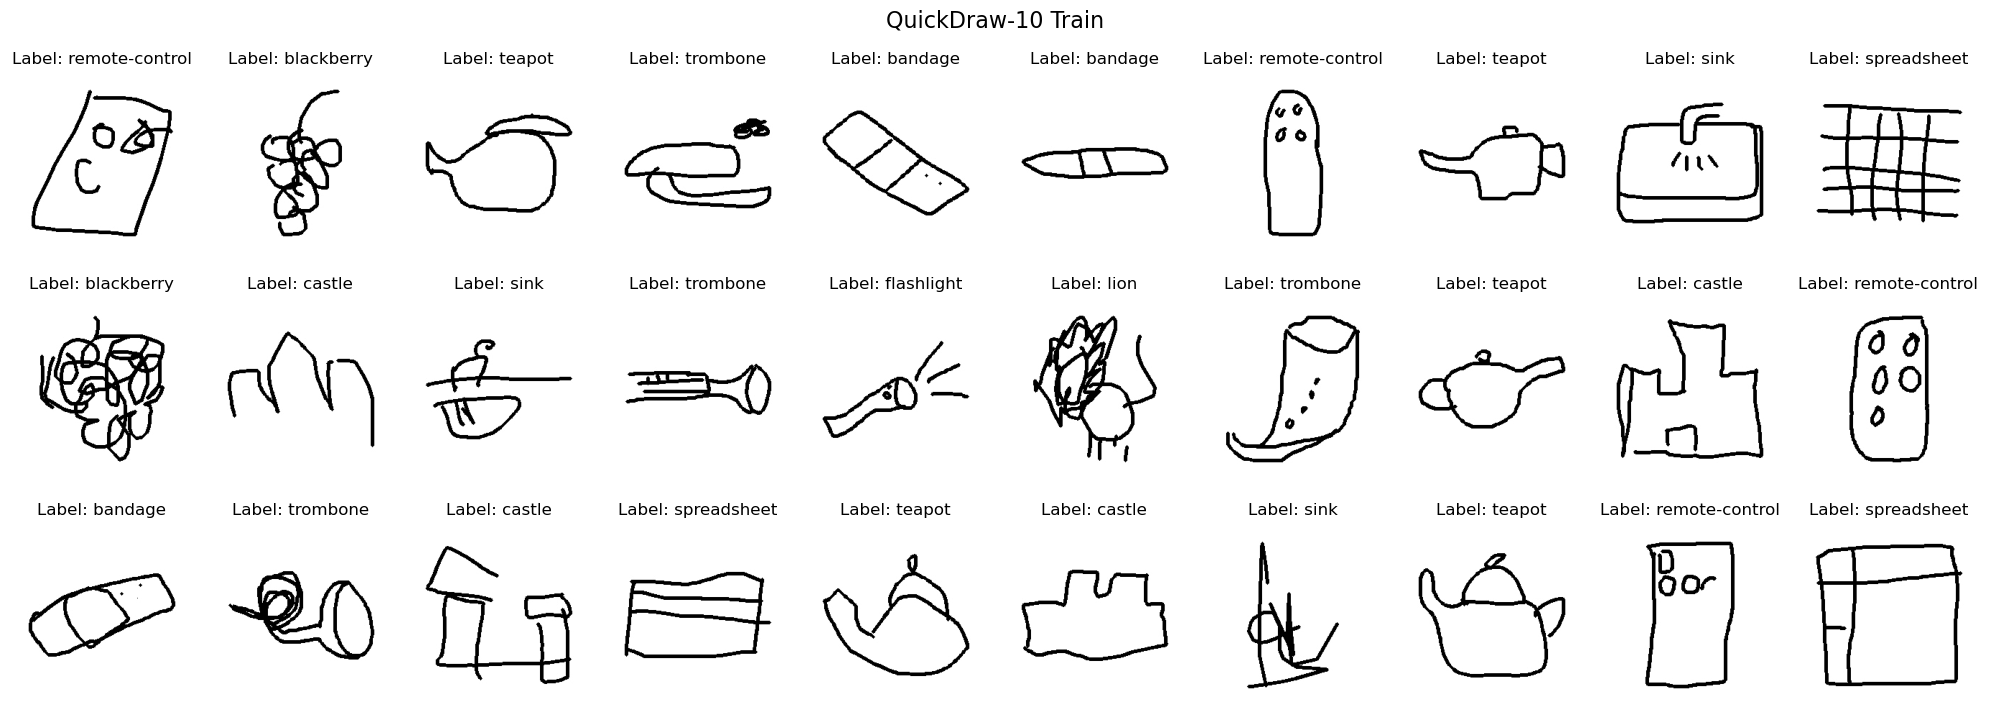

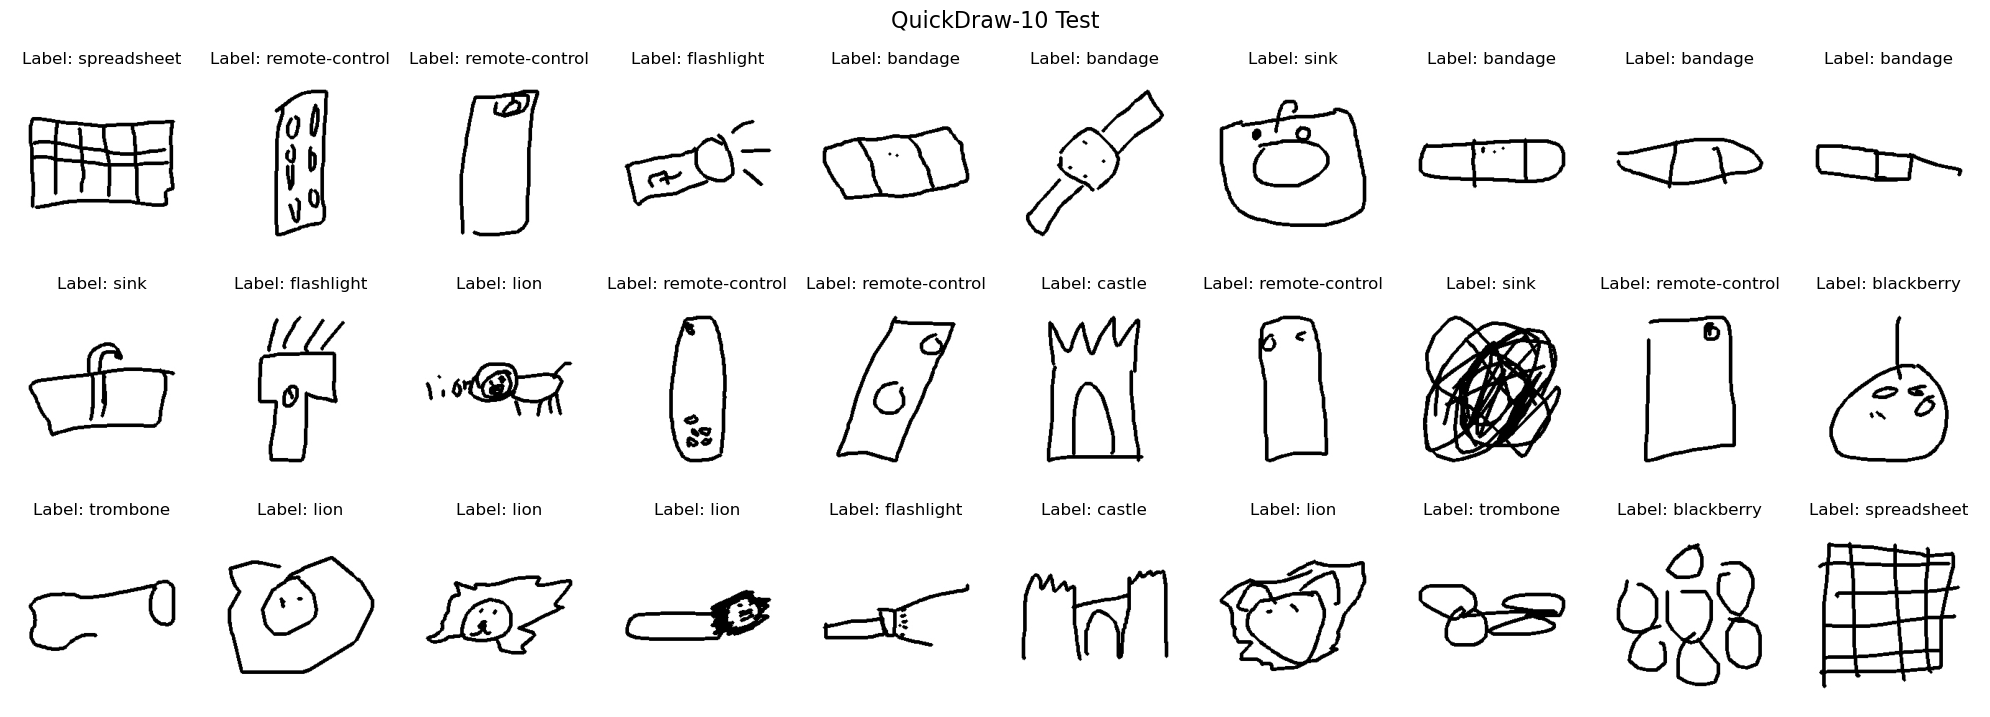

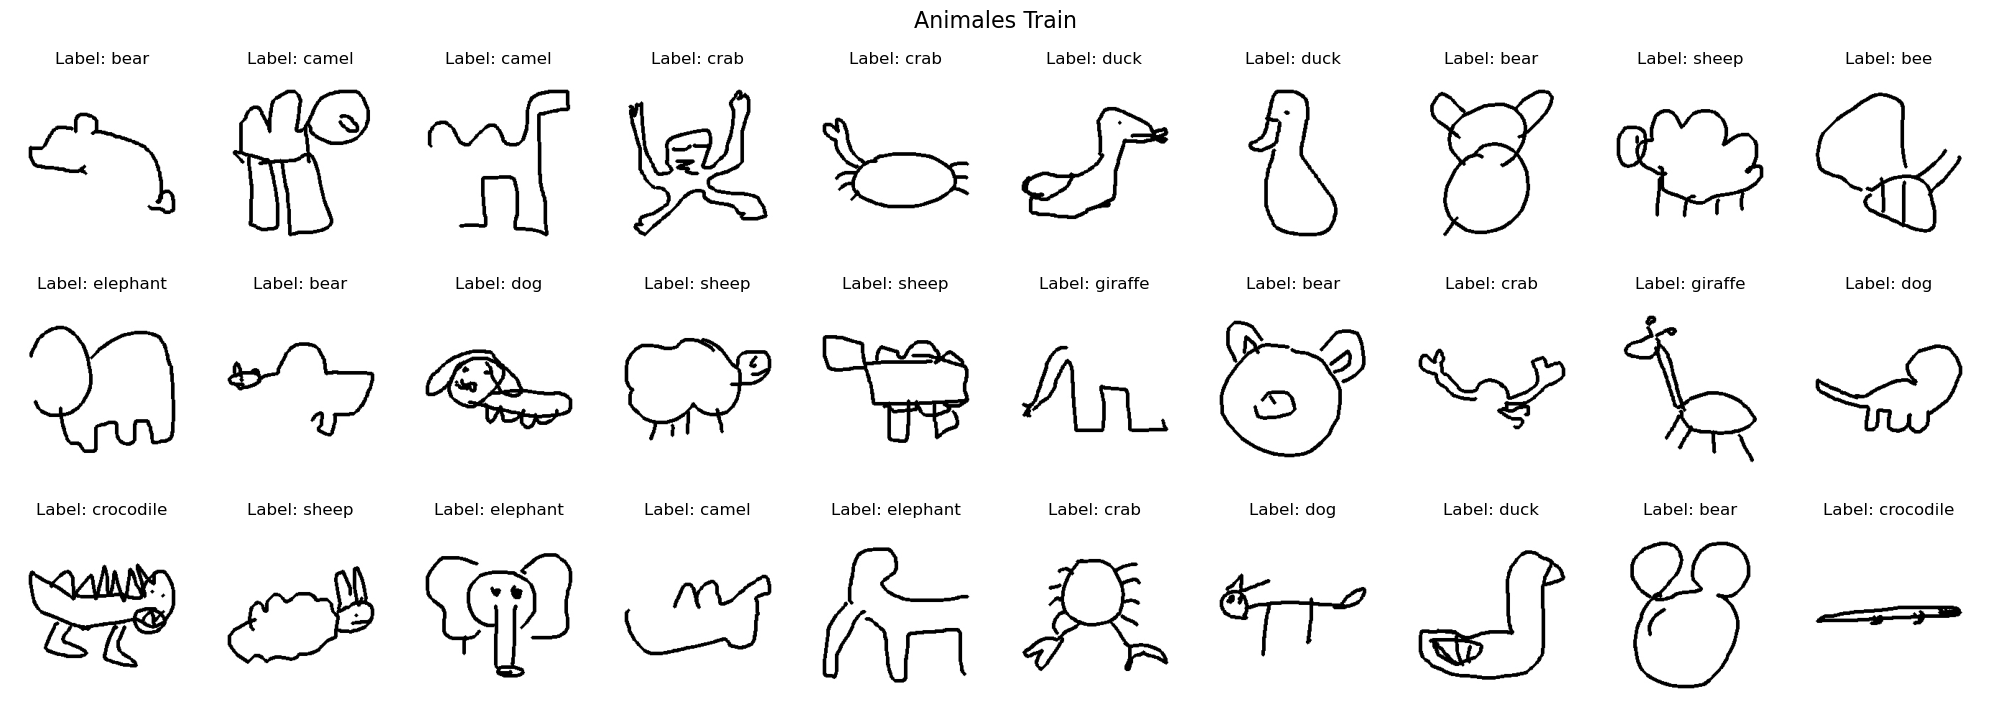

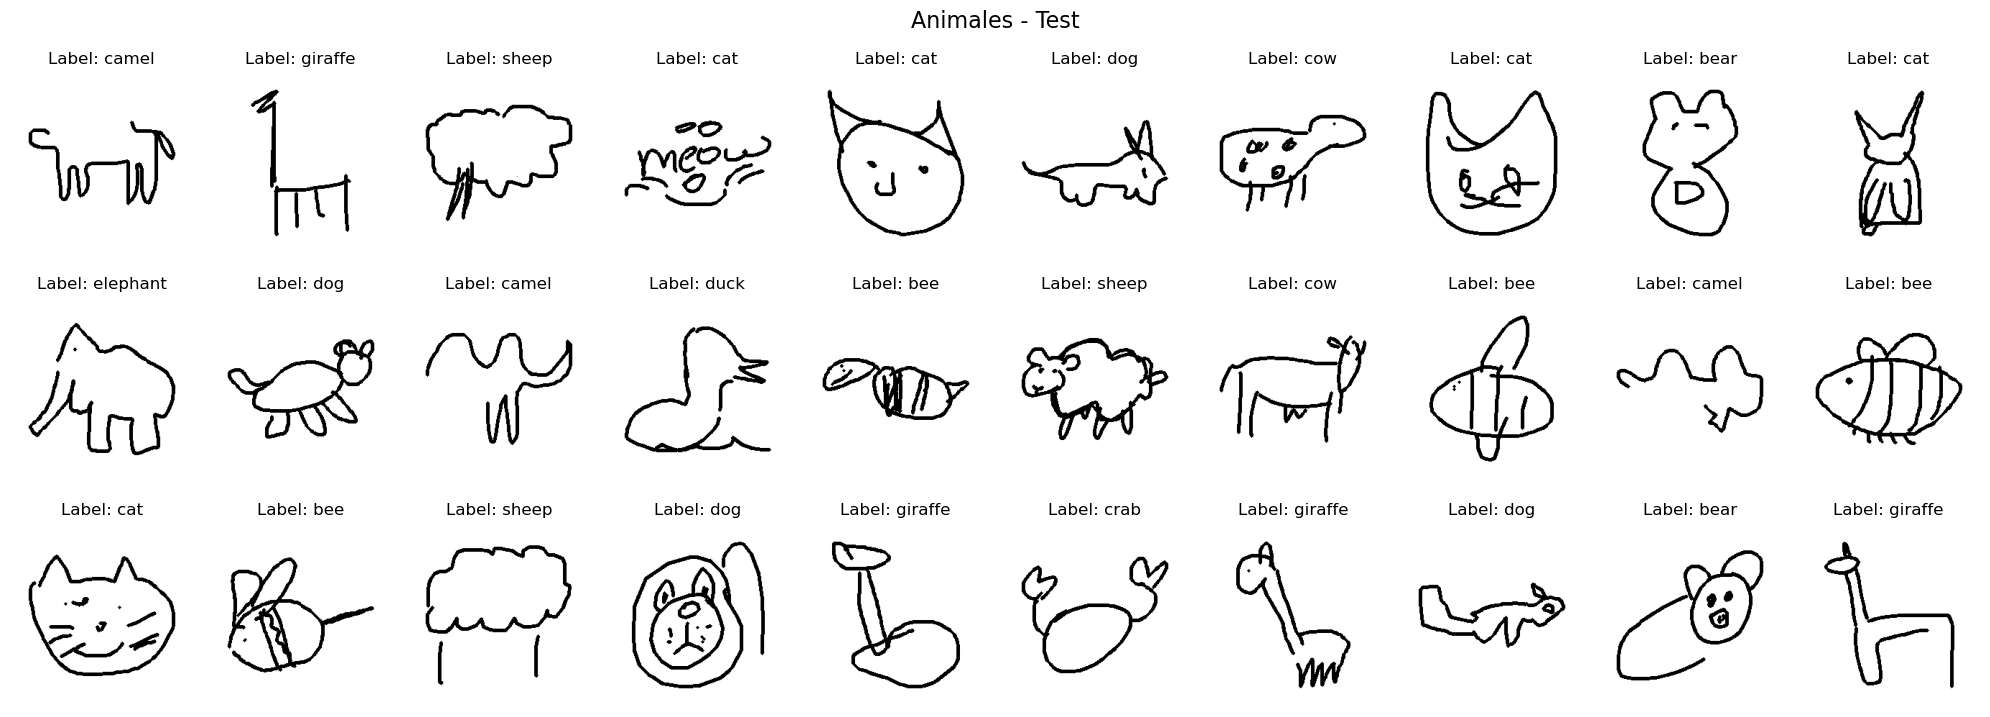

In [10]:
# Para QuickDraw-10
mostrar_imagenes_random(X_train10, y_train10, cantidad=30, etiquetas_dict=etiquetas_quickdraw10, titulo="QuickDraw-10 Train")
mostrar_imagenes_random(X_test10, y_test10, cantidad=30, etiquetas_dict=etiquetas_quickdraw10, titulo="QuickDraw-10 Test")

# Diccionario inverso para mostrar etiquetas
etiquetas_animals_inv = {v: k for k, v in etiquetas_animals.items()}
#  QuickDraw-Animals 
mostrar_imagenes_random(X_trainA, y_trainA, cantidad=30, etiquetas_dict=etiquetas_animals_inv, titulo="Animales Train")
mostrar_imagenes_random(X_testA, y_testA, cantidad=30, etiquetas_dict=etiquetas_animals_inv, titulo="Animales - Test")



## Descripción de los Modelos MLP

# MLP1 - 2 capas ReLU + CrossEntropy
Modelo con dos capas ocultas de tamaño 256 y 128 neuronas, activación ReLU en ambas capas, y función de pérdida CrossEntropyLoss. Ideal para clasificación básica con buena capacidad de aprendizaje.

# MLP2 - 3 capas Tanh/ReLU + CrossEntropy
Modelo con tres capas ocultas de tamaños 512, 256 y 128 neuronas. Las funciones de activación son Tanh en la primera capa y ReLU en las dos siguientes. Usa CrossEntropyLoss para la clasificación, proporcionando más profundidad para capturar patrones complejos.

# MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss
Modelo más profundo con cuatro capas ocultas (256, 128, 64, 32 neuronas), combinando activaciones LeakyReLU, Tanh y ReLU. Utiliza NLLLoss como función de pérdida, por lo que la salida aplica LogSoftmax.

In [11]:
modelos = [
    {
        "hidden_layers": [256, 128],
        "activation_fns": [nn.ReLU, nn.ReLU],
        "loss_fn_class": nn.CrossEntropyLoss,
        "nombre": "MLP1 - 2 capas ReLU + CrossEntropy"
    },
    {
        "hidden_layers": [512, 256, 128],
        "activation_fns": [nn.Tanh, nn.ReLU, nn.ReLU],
        "loss_fn_class": nn.CrossEntropyLoss,
        "nombre": "MLP2 - 3 capas Tanh/ReLU + CrossEntropy"
    },
    {
        "hidden_layers": [256, 128, 64, 32],
        "activation_fns": [nn.LeakyReLU, nn.Tanh, nn.ReLU, nn.ReLU],
        "loss_fn_class": nn.NLLLoss,
        "nombre": "MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss"
    }
]


In [12]:
class MLP_general(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fns, output_size, use_logsoftmax=False):
        super().__init__()
        layers = []
        in_features = input_size
        for h, act_fn in zip(hidden_layers, activation_fns):
            layers.append(nn.Linear(in_features, h))
            layers.append(act_fn())
            in_features = h
        layers.append(nn.Linear(in_features, output_size))
        if use_logsoftmax:
            layers.append(nn.LogSoftmax(dim=1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


In [17]:
def evaluar_varias_veces_general(X_train_np, y_train_np, X_test_np, y_test_np,
                                hidden_layers, activation_fns, loss_fn_class,
                                repeticiones=5, epochs=20, lr=0.001, batch_size=32, etiquetas=None,
                                use_logsoftmax=False):

    accuracies = []
    accuracies_por_clase = []
    matrices_conf = []

    input_size = X_train_np.shape[1]
    output_size = len(np.unique(y_train_np))

    X_train_all = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_all = torch.tensor(y_train_np, dtype=torch.long)
    X_test = torch.tensor(X_test_np, dtype=torch.float32)
    y_test = torch.tensor(y_test_np, dtype=torch.long)

    for i in range(repeticiones):
        model = MLP_general(input_size, hidden_layers, activation_fns, output_size, use_logsoftmax)
        criterion = loss_fn_class()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        dataset = torch.utils.data.TensorDataset(X_train_all, y_train_all)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            loop = trange(len(loader), desc=f"Iteración {i+1} Epoch {epoch+1}", leave=False)
            for j, (inputs, labels) in zip(loop, loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                acc = correct / total
                loop.set_postfix(accuracy=acc, loss=running_loss / (j + 1))

        model.eval()
        with torch.no_grad():
            outputs = model(X_test)
            preds = outputs.argmax(dim=1)
            acc_total = accuracy_score(y_test, preds)
            loss = criterion(outputs, y_test).item()
            matriz = confusion_matrix(y_test, preds)

        with np.errstate(divide='ignore', invalid='ignore'):
            clase_sum = matriz.sum(axis=0)
            clase_sum[clase_sum == 0] = 1
            acc_clase = matriz.diagonal() / clase_sum

        accuracies.append(acc_total)
        accuracies_por_clase.append(acc_clase)
        matrices_conf.append(matriz)

        print(f"\nIteración {i} - Accuracy Total: {acc_total:.4f} - Loss: {loss:.4f}")
        print(f"Accuracy por cada clase en Iteración {i} : {acc_clase}")
        print("-" * 80)

    acc_median = np.median(accuracies)
    acc_clase_median = np.nanmedian(np.array(accuracies_por_clase), axis=0)
    median_cm = np.nanmedian(np.array(matrices_conf), axis=0).astype(int)

    disp = ConfusionMatrixDisplay(confusion_matrix=median_cm, display_labels=etiquetas)
    disp.plot(xticks_rotation=45,cmap='Blues')
    plt.title("Matriz de Confusión Mediana")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    if etiquetas is None:
        clases = np.arange(len(acc_clase_median))
    elif isinstance(etiquetas, dict):
        clases = [etiquetas[k] for k in sorted(etiquetas.keys())]
    else:
        clases = etiquetas

    plt.bar(clases, acc_clase_median)
    plt.title("Accuracy por clase (mediana)")
    plt.xlabel("Clases")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()
    return accuracies, acc_median, acc_clase_median


## MLP 1,2 y 3 con Quickdraw-10


Entrenando MLP1 - 2 capas ReLU + CrossEntropy...



Iteración 0 - Accuracy Total: 0.7264 - Loss: 1.9650
Accuracy por cada clase en Iteración 0 : [0.71428571 0.73809524 0.76785714 0.8034188  0.58156028 0.74444444
 0.71755725 0.79816514 0.83471074 0.56989247]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.7230 - Loss: 2.1086
Accuracy por cada clase en Iteración 1 : [0.69230769 0.78512397 0.71428571 0.73170732 0.61363636 0.73333333
 0.71851852 0.7421875  0.83050847 0.6626506 ]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.7281 - Loss: 2.0996
Accuracy por cada clase en Iteración 2 : [0.60784314 0.70542636 0.74782609 0.82300885 0.66929134 0.8125
 0.83018868 0.73228346 0.84545455 0.58490566]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.7221 - Loss: 2.0148
Accuracy por cada clase en Iteración 3 : [0.6969697  0.7962963  0.76521739 0.73387097 0.65       0.67619048
 0.77391304 0.76033058 0.7983871  0.54901961]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.7093 - Loss: 2.3046
Accuracy por cada clase en Iteración 4 : [0.63013699 0.84158416 0.79487179 0.76923077 0.60869565 0.62698413
 0.79245283 0.70588235 0.80645161 0.58510638]
--------------------------------------------------------------------------------


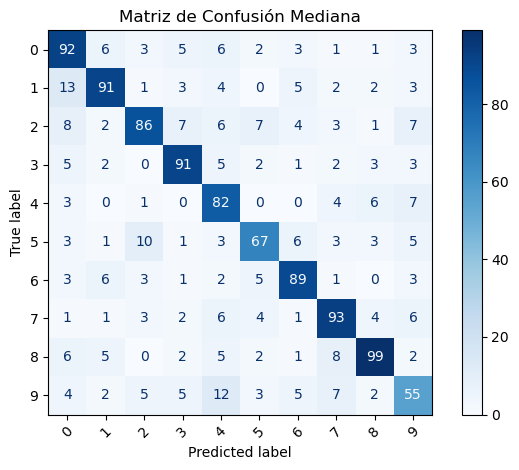

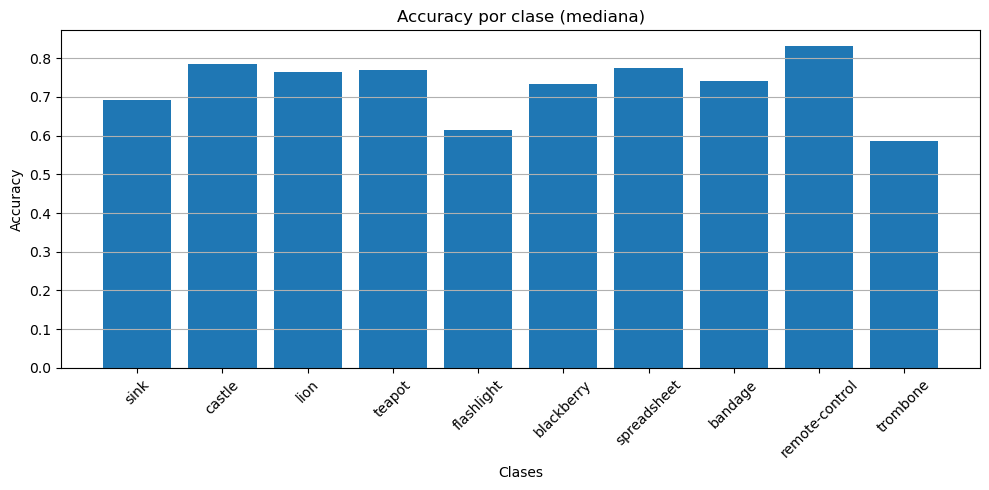

Mediana accuracy total MLP1 - 2 capas ReLU + CrossEntropy: 0.7230

Entrenando MLP2 - 3 capas Tanh/ReLU + CrossEntropy...



Iteración 0 - Accuracy Total: 0.7196 - Loss: 2.3501
Accuracy por cada clase en Iteración 0 : [0.73170732 0.69230769 0.70542636 0.92771084 0.6        0.76470588
 0.75       0.8627451  0.7751938  0.51538462]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.7256 - Loss: 1.9616
Accuracy por cada clase en Iteración 1 : [0.7        0.81553398 0.7394958  0.76859504 0.66666667 0.69306931
 0.77777778 0.67375887 0.76744186 0.65346535]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.7144 - Loss: 2.4501
Accuracy por cada clase en Iteración 2 : [0.68148148 0.72307692 0.80434783 0.8490566  0.61864407 0.6031746
 0.81730769 0.78947368 0.75       0.55752212]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.7264 - Loss: 2.2794
Accuracy por cada clase en Iteración 3 : [0.70289855 0.72727273 0.76530612 0.95604396 0.69230769 0.66037736
 0.73043478 0.775      0.76865672 0.54761905]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.7127 - Loss: 2.3659
Accuracy por cada clase en Iteración 4 : [0.73684211 0.72131148 0.75675676 0.82142857 0.5862069  0.67924528
 0.6744186  0.78761062 0.81355932 0.5625    ]
--------------------------------------------------------------------------------


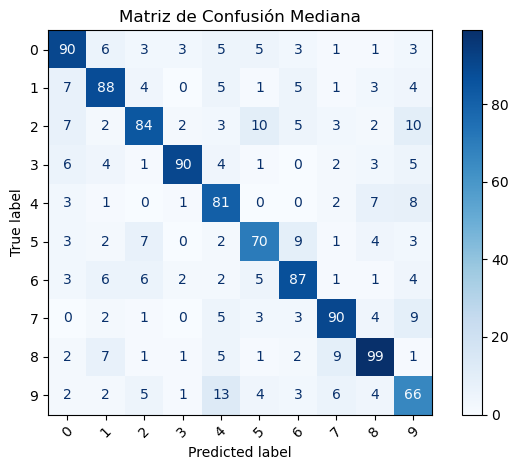

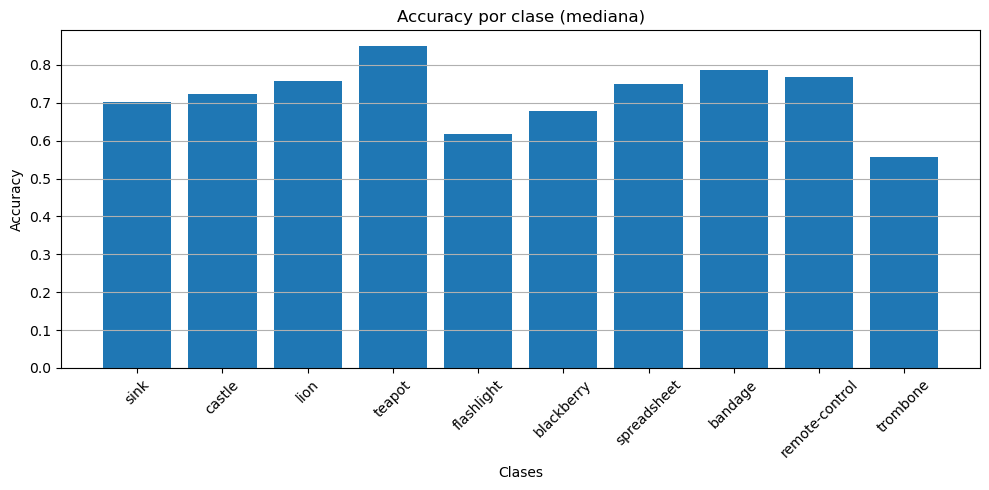

Mediana accuracy total MLP2 - 3 capas Tanh/ReLU + CrossEntropy: 0.7196

Entrenando MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss...



Iteración 0 - Accuracy Total: 0.7187 - Loss: 1.7768
Accuracy por cada clase en Iteración 0 : [0.66165414 0.82242991 0.80851064 0.78813559 0.6171875  0.76829268
 0.752      0.75609756 0.76642336 0.49579832]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.7058 - Loss: 2.0569
Accuracy por cada clase en Iteración 1 : [0.76699029 0.71544715 0.77192982 0.79439252 0.6746988  0.74468085
 0.77777778 0.7265625  0.77862595 0.44571429]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.7033 - Loss: 1.9954
Accuracy por cada clase en Iteración 2 : [0.67716535 0.78640777 0.71929825 0.71851852 0.65789474 0.64864865
 0.72727273 0.71428571 0.85321101 0.53636364]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.7187 - Loss: 1.7864
Accuracy por cada clase en Iteración 3 : [0.76785714 0.78217822 0.62222222 0.73913043 0.62773723 0.67326733
 0.76521739 0.83018868 0.83333333 0.57943925]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.7041 - Loss: 1.8557
Accuracy por cada clase en Iteración 4 : [0.70634921 0.66666667 0.74257426 0.78787879 0.63432836 0.61111111
 0.81632653 0.79439252 0.784      0.55045872]
--------------------------------------------------------------------------------


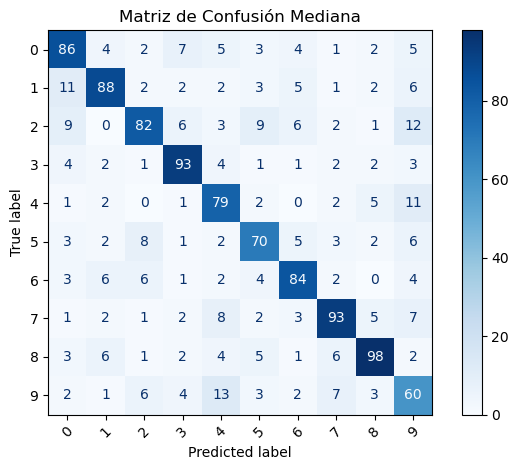

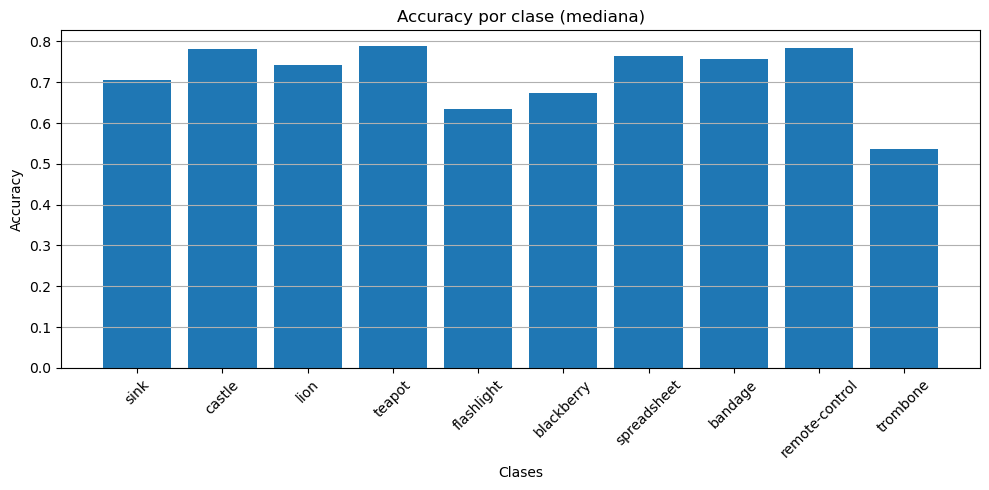

Mediana accuracy total MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss: 0.7058


In [18]:
for modelo in modelos:
    print(f"\nEntrenando {modelo['nombre']}...")
    use_logsoftmax = modelo['loss_fn_class'] == nn.NLLLoss
    accs, mediana_acc, acc_clase_mediana = evaluar_varias_veces_general(
        X_train10_pca, y_train10, X_test10_pca, y_test10,
        hidden_layers=modelo['hidden_layers'],
        activation_fns=modelo['activation_fns'],
        loss_fn_class=modelo['loss_fn_class'],
        repeticiones=5,
        epochs=20,
        etiquetas=etiquetas_quickdraw10,
        use_logsoftmax=use_logsoftmax
    )
    print(f"Mediana accuracy total {modelo['nombre']}: {mediana_acc:.4f}")


## MLP 1,2 y 3 con Quickdraw-Animals


Entrenando MLP1 - 2 capas ReLU + CrossEntropy en QuickDraw-Animals...



Iteración 0 - Accuracy Total: 0.5327 - Loss: 4.2707
Accuracy por cada clase en Iteración 0 : [0.56666667 0.51234568 0.56164384 0.52459016 0.51886792 0.35064935
 0.56521739 0.69651741 0.56315789 0.46327684 0.27604167 0.75630252]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.5244 - Loss: 4.2931
Accuracy por cada clase en Iteración 1 : [0.61904762 0.53038674 0.62209302 0.46448087 0.6        0.38020833
 0.46415094 0.6372549  0.50819672 0.49714286 0.23834197 0.7231405 ]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.5236 - Loss: 4.1807
Accuracy por cada clase en Iteración 2 : [0.53246753 0.52777778 0.54314721 0.43192488 0.61290323 0.37788018
 0.52       0.72159091 0.5        0.44859813 0.30054645 0.77973568]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.5160 - Loss: 4.5289
Accuracy por cada clase en Iteración 3 : [0.5698324  0.5030303  0.5186722  0.51445087 0.48165138 0.40588235
 0.47244094 0.71764706 0.63380282 0.46969697 0.25984252 0.74042553]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.5365 - Loss: 4.2128
Accuracy por cada clase en Iteración 4 : [0.48056537 0.47169811 0.59887006 0.50292398 0.67424242 0.41954023
 0.47169811 0.70857143 0.61139896 0.52432432 0.29047619 0.77477477]
--------------------------------------------------------------------------------


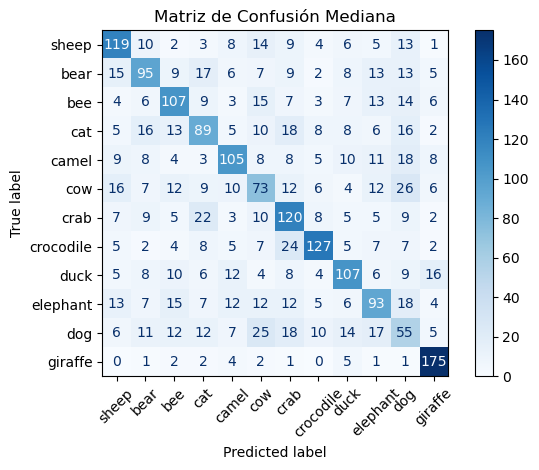

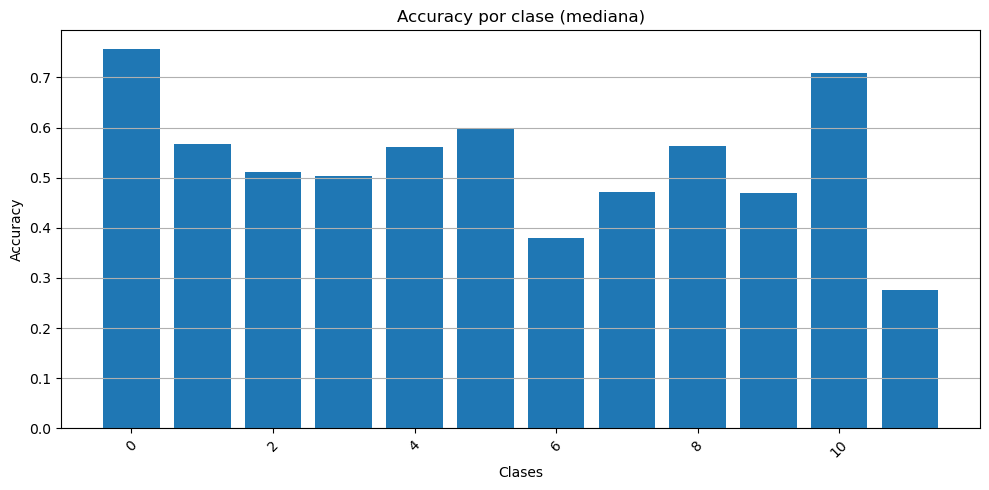

Mediana accuracy total MLP1 - 2 capas ReLU + CrossEntropy en QuickDraw-Animals: 0.5244

Entrenando MLP2 - 3 capas Tanh/ReLU + CrossEntropy en QuickDraw-Animals...



Iteración 0 - Accuracy Total: 0.5123 - Loss: 4.2565
Accuracy por cada clase en Iteración 0 : [0.55       0.4852071  0.55263158 0.41284404 0.55952381 0.39655172
 0.49321267 0.63888889 0.51315789 0.46368715 0.27692308 0.73858921]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.5206 - Loss: 4.1475
Accuracy por cada clase en Iteración 1 : [0.55660377 0.48717949 0.48031496 0.47916667 0.47826087 0.50299401
 0.48917749 0.68674699 0.50691244 0.47474747 0.32716049 0.73417722]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.5281 - Loss: 4.0900
Accuracy por cada clase en Iteración 2 : [0.59793814 0.46443515 0.56164384 0.45454545 0.52760736 0.44871795
 0.53017241 0.67231638 0.57526882 0.43457944 0.27225131 0.76956522]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.5056 - Loss: 4.1235
Accuracy por cada clase en Iteración 3 : [0.59756098 0.50920245 0.61146497 0.49462366 0.43668122 0.37878788
 0.46808511 0.61256545 0.48760331 0.41666667 0.28961749 0.78923767]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.5177 - Loss: 4.2786
Accuracy por cada clase en Iteración 4 : [0.56542056 0.45454545 0.53275109 0.47701149 0.67256637 0.37823834
 0.5        0.60425532 0.55665025 0.49358974 0.22321429 0.78854626]
--------------------------------------------------------------------------------


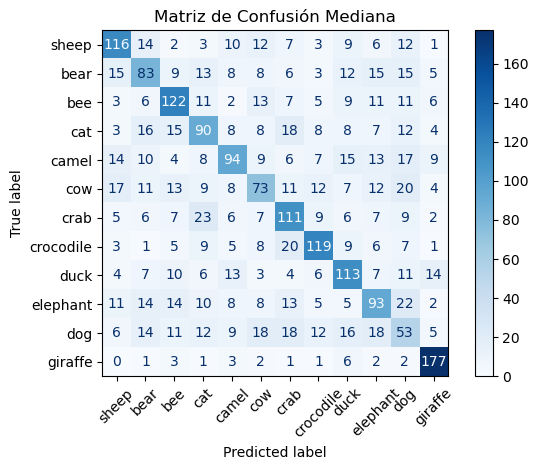

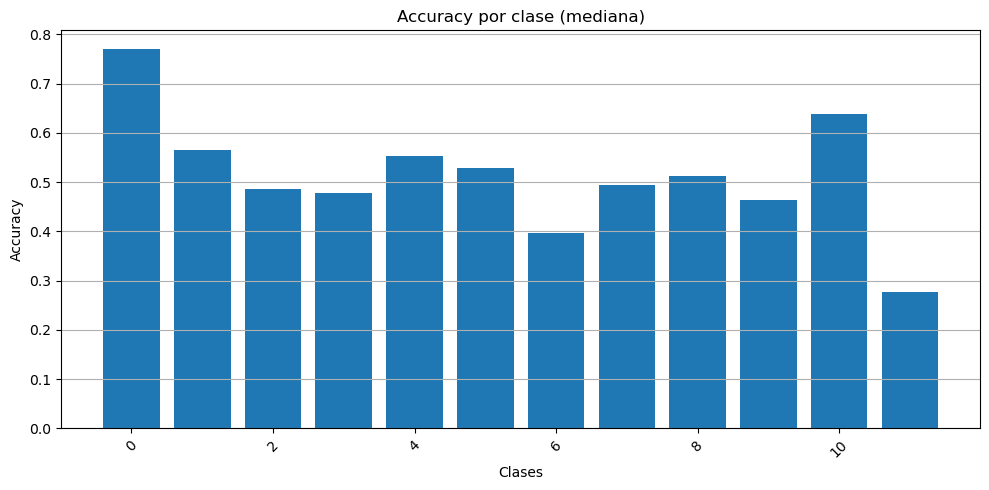

Mediana accuracy total MLP2 - 3 capas Tanh/ReLU + CrossEntropy en QuickDraw-Animals: 0.5177

Entrenando MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss en QuickDraw-Animals...



Iteración 0 - Accuracy Total: 0.5240 - Loss: 3.4291
Accuracy por cada clase en Iteración 0 : [0.59615385 0.48255814 0.53679654 0.46666667 0.4741784  0.4278607
 0.46351931 0.6954023  0.56185567 0.49189189 0.28176796 0.77092511]
--------------------------------------------------------------------------------



Iteración 1 - Accuracy Total: 0.5110 - Loss: 3.3372
Accuracy por cada clase en Iteración 1 : [0.58415842 0.44444444 0.55868545 0.53246753 0.50471698 0.37190083
 0.43542435 0.69886364 0.52459016 0.49090909 0.2513369  0.78536585]
--------------------------------------------------------------------------------



Iteración 2 - Accuracy Total: 0.5102 - Loss: 3.5189
Accuracy por cada clase en Iteración 2 : [0.55156951 0.43396226 0.52604167 0.43668122 0.525      0.40969163
 0.57407407 0.6875     0.4875     0.53125    0.23696682 0.8       ]
--------------------------------------------------------------------------------



Iteración 3 - Accuracy Total: 0.5006 - Loss: 3.5912
Accuracy por cada clase en Iteración 3 : [0.51851852 0.41666667 0.58695652 0.49425287 0.58741259 0.3375
 0.56593407 0.7        0.55113636 0.40686275 0.20689655 0.74893617]
--------------------------------------------------------------------------------



Iteración 4 - Accuracy Total: 0.5261 - Loss: 3.4088
Accuracy por cada clase en Iteración 4 : [0.61256545 0.4973822  0.55924171 0.48587571 0.5106383  0.38586957
 0.46443515 0.58232932 0.47457627 0.50241546 0.3030303  0.86082474]
--------------------------------------------------------------------------------


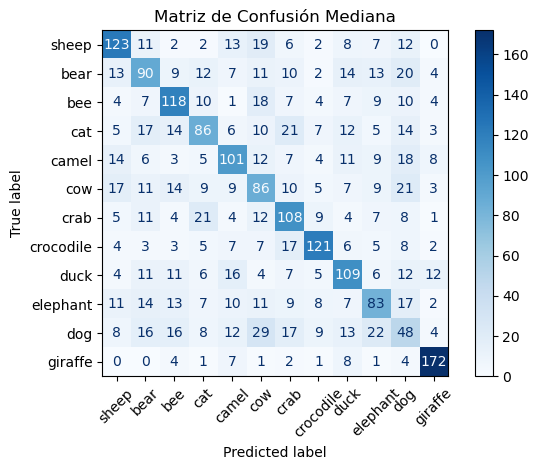

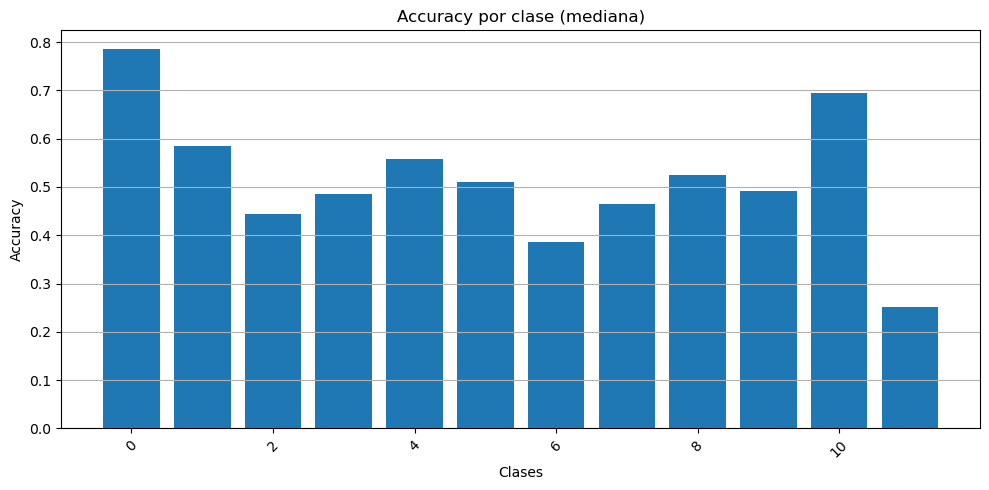

Mediana accuracy total MLP3 - 4 capas LeakyReLU/Tanh/ReLU + NLLLoss en QuickDraw-Animals: 0.5110


In [19]:
for modelo in modelos:
    print(f"\nEntrenando {modelo['nombre']} en QuickDraw-Animals...")
    use_logsoftmax = modelo['loss_fn_class'] == nn.NLLLoss
    accs, mediana_acc, acc_clase_mediana = evaluar_varias_veces_general(
        X_trainA_pca, y_trainA, X_testA_pca, y_testA,
        hidden_layers=modelo['hidden_layers'],
        activation_fns=modelo['activation_fns'],
        loss_fn_class=modelo['loss_fn_class'],
        repeticiones=5,
        epochs=20,
        etiquetas=etiquetas_animals,
        use_logsoftmax=use_logsoftmax
    )
    print(f"Mediana accuracy total {modelo['nombre']} en QuickDraw-Animals: {mediana_acc:.4f}")
